In [92]:
import numpy as np
import os
import pandas as pd
import torch
import albumentations as A
import albumentations.pytorch
import cv2
import sys
import random
import csv
import json
import matplotlib.pyplot as plt

sys.path.append('../')
from visualize import visualize
from utils import *

%matplotlib inline

In [93]:
df = pd.read_csv('../saved/df.csv')
df.shape

(24782, 14)

In [94]:
train = pd.read_csv('../saved/train.csv')
test = pd.read_csv('../saved/test.csv')

In [98]:
print(train.shape)
print(train.drop_duplicates().shape)

print(test.shape)
print(test.drop_duplicates().shape)

(17120, 14)
(17120, 14)
(5523, 14)
(5523, 14)


In [3]:
df.label.value_counts()

AS                           6562
Negative                     4468
LS                           3083
ASC-US                       2897
LSIL                         1689
ASC-US with HPV infection    1603
AH                            962
HS                            667
HSIL                          548
C                             527
LSIL with HPV infection       479
Candida                       402
N - Endocervical Cell         306
ASC-H                         263
HSIL with HPV infection       142
HN                            102
Benign atypia                  46
Carcinoma                      18
H                               9
판독불가                            4
ASCUS-SIL                       2
N - Endometrial cell            1
ASC-H with HPV infection        1
SC                              1
Name: label, dtype: int64

In [4]:
print(df.shape)
df['label'] = df.label.apply(lambda x : CLASS_MAPPER[str(x)])
df = drop_wrong(df)
df.reset_index(drop=True, inplace=True)
print(df.shape)

(24782, 14)
(22662, 14)


In [5]:
df.label.value_counts()

ASC-US       11057
LSIL          5248
Negative      3647
HSIL          1466
ASC-H         1225
Carcinoma       19
Name: label, dtype: int64

In [6]:
columns = 'label'
all_size = len(df)
ascus_df = df[df[columns]=='ASC-US']
asch_df = df[df[columns]=='ASC-H']
neg_df = df[df[columns]=='Negative']
hsil_df = df[df[columns]=='HSIL']
lsil_df = df[df[columns]=='LSIL']
carcinoma_df = df[df[columns]=='Carcinoma']
sum_partial = len(ascus_df) + len(asch_df) + len(neg_df) + len(hsil_df) + len(lsil_df) + len(carcinoma_df)
print(all_size, sum_partial)

22662 22662


In [7]:
def split_by_group(df, ratio, seed ) :
    train_inds, test_inds = next(GroupShuffleSplit(test_size=ratio,
                                                   train_size=(1-ratio),
                                                    n_splits=10, 
                                                    random_state = seed).split(df, groups=df['task']))
    return train_inds, test_inds

In [8]:
train_li = []
test_li = []
ratio = 0.25
seed = 0

for tdf in list([ascus_df, asch_df, neg_df, hsil_df, lsil_df]) :
    tr_inds, te_inds = split_by_group(tdf, ratio, seed)
    temp_tr = tdf.iloc[tr_inds]
    temp_te = tdf.iloc[te_inds]
    train_li.append(temp_tr)
    test_li.append(temp_te)
train_df = pd.concat(train_li)
test_df = pd.concat(test_li)

In [9]:
train_dict = (train_df.label.value_counts()).to_dict()
train_dict

{'ASC-US': 7093, 'LSIL': 3485, 'Negative': 2713, 'HSIL': 1097, 'ASC-H': 798}

In [10]:
test_dict = test_df.label.value_counts().to_dict()
test_dict

{'ASC-US': 3964, 'LSIL': 1763, 'Negative': 934, 'ASC-H': 427, 'HSIL': 369}

In [11]:
ratio_dict = {}
for la in train_dict.keys() :
    ratio_dict[la] = float(test_dict[la]/(train_dict[la]+test_dict[la]))

In [12]:
ratio_dict

{'ASC-US': 0.3585059238491453,
 'LSIL': 0.3359375,
 'Negative': 0.2561009048533041,
 'HSIL': 0.25170532060027284,
 'ASC-H': 0.3485714285714286}

In [13]:
ratio_df = pd.DataFrame.from_dict(ratio_dict, 'index', columns=['ratio'])
ratio_df

,ratio
ASC-US,0.358506
LSIL,0.335938
Negative,0.256101
HSIL,0.251705
ASC-H,0.348571


<AxesSubplot:>

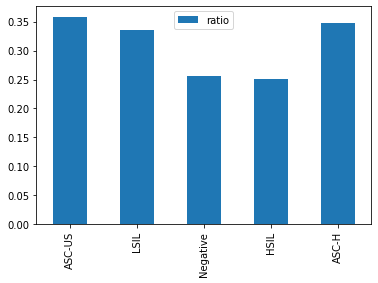

In [14]:
ratio_df.plot.bar()

In [23]:
import pandas as pd

df = pd.DataFrame(
    {
        "x": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120],
        "id": [1, 1, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5],
        "label": ["a", "a", "a", "b", "a", "b", "b", "b", "a", "b", "a", "b"],
    }
)

In [24]:
TRAIN_TEST_SPLIT_PERC = 0.75
uniques = df["id"].unique()
print(uniques)
sep = int(len(uniques) * TRAIN_TEST_SPLIT_PERC)
print(sep)
df = df.sample(frac=1).reset_index(drop=True) #For shuffling your data
train_ids, test_ids = uniques[:sep], uniques[sep:]
train_df, test_df = df[df.id.isin(train_ids)], df[df.id.isin(test_ids)]


print("\nTRAIN DATAFRAME\n", train_df)
print("\nTEST DATAFRAME\n", test_df)

[1 2 3 4 5]
3

TRAIN DATAFRAME
      x  id label
0   20   1     a
2   50   2     a
4   30   1     a
6   60   2     b
7   70   3     b
8   10   1     a
10  80   3     b
11  40   1     b

TEST DATAFRAME
      x  id label
1  120   5     b
3  110   5     a
5  100   4     b
9   90   4     a


In [26]:
df = pd.read_csv('../saved/df.csv')
df['label'] = df.label.apply(lambda x : CLASS_MAPPER[str(x)])
df = drop_wrong(df)
df.reset_index(drop=True, inplace=True)
neg_df = df[df[columns]=='Negative']
neg_df.head()

,file_name,task,label,xmin,ymin,w,h,occluded,des,cell_type,bbox,area,ratio,ID
610,patch_images/2021.01.07/LBC84-20210104(1)/LBC8...,[LSIL] LBC84,Negative,775,300,100,137,0,NaN,Superficial cell,"[775, 300, 100, 137]",117,0.854358,408
617,patch_images/2021.01.07/LBC84-20210104(1)/LBC8...,[LSIL] LBC84,Negative,1159,887,110,171,0,NaN,Superficial cell,"[1159, 887, 110, 171]",137,0.802044,413
1751,patch_images/2021.06.01/LBC1455-20210127(1)/LB...,LBC1455,Negative,994,1047,129,109,0,NaN,NaN,"[994, 1047, 129, 109]",118,1.087882,1584
1752,patch_images/2021.06.01/LBC1455-20210127(1)/LB...,LBC1455,Negative,939,1595,256,196,0,NaN,NaN,"[939, 1595, 256, 196]",224,1.142857,1585
1753,patch_images/2021.06.01/LBC1455-20210127(1)/LB...,LBC1455,Negative,1820,390,114,141,0,NaN,NaN,"[1820, 390, 114, 141]",126,0.899172,1586


In [85]:
TRAIN_TEST_SPLIT_PERC = 0.75
uniques = neg_df["task"].unique()
print(uniques)
sep = int(len(uniques) * TRAIN_TEST_SPLIT_PERC)
print(sep)

best_ratio = 0
best_unique = []
best_train_df = []
best_test_df = []
for i in range(40) :
    random.shuffle(uniques)
    df = df.sample(frac=1).reset_index(drop=True) #For shuffling your data
    train_ids, test_ids = uniques[:sep], uniques[sep:]
    train_df, test_df = neg_df[neg_df.task.isin(train_ids)], neg_df[neg_df.task.isin(test_ids)]
    ratio = len(test_df)/(len(test_df) + len(train_df))
    if ratio > best_ratio and ratio < (1-TRAIN_TEST_SPLIT_PERC) :
        best_ratio = ratio
        best_unique.append(uniques)
        best_train_df.append(train_df)
        best_test_df.append(test_df)

print(best_ratio)
print(len(best_test_df[-1])/(len(best_test_df[-1]) + len(best_train_df[-1])))

['[LSIL] LBC84' 'LBC1455' 'LBC56' 'LBC108' 'LBC52' 'LBC1291' 'LBC277'
 'LBC14' 'LBC227' 'LBC115' 'LBC779' 'LBC27' 'LBC767' 'LBC962' 'LBC1499'
 'LBC95' 'LBC10' 'LBC44']
13
0.24869755963805867
0.24869755963805867


In [86]:
TRAIN_TEST_SPLIT_PERC = 0.75
uniques = hsil_df["task"].unique()
print(uniques)
sep = int(len(uniques) * TRAIN_TEST_SPLIT_PERC)
print(sep)

best_ratio = 0
best_unique = []
best_train_df = []
best_test_df = []
for i in range(40) :
    random.shuffle(uniques)
    df = df.sample(frac=1).reset_index(drop=True) #For shuffling your data
    train_ids, test_ids = uniques[:sep], uniques[sep:]
    train_df, test_df = hsil_df[hsil_df.task.isin(train_ids)], hsil_df[hsil_df.task.isin(test_ids)]
    ratio = len(test_df)/(len(test_df) + len(train_df))
    if ratio > best_ratio and ratio < (1-TRAIN_TEST_SPLIT_PERC) :
        best_ratio = ratio
        best_unique.append(uniques)
        best_train_df.append(train_df)
        best_test_df.append(test_df)

print(best_ratio)
print(len(best_test_df[-1])/(len(best_test_df[-1]) + len(best_train_df[-1])))

['[LSIL] LBC427' 'LBC1098' 'LBC1571' '[ASCUS] LBC139' 'LBC1427'
 '[ASC-H] LBC203' 'LBC2315' '[HS6] LBC253' '[ASCUS] LBC138' '[AS6] LBC358'
 '[ASCUS] LBC583' '[ASC-H] LBC201' '[AS6] LBC421' 'LBC1572' 'LBC2170'
 'LBC1790' '[ASCUS] LBC186' '[LSIL] LBC85' 'LBC1350' 'LBC1349'
 '[HSIL] LBC360' '[LSIL] LBC428' '[LS6] LBC247' '[AS6] LBC341' 'LBC2239'
 'LBC1018' 'LBC1639' 'LBC1020' 'LBC1021' '[HSIL] LBC606' 'LBC1637'
 'LBC1947' '[ASCUS] LBC176' '[HSIL] LBC681' 'LBC892' 'LBC813' 'LBC2314'
 '[ASCUS] LBC302' '[ASCUS] LBC177' '[HSIL] LBC311' 'LBC1428' 'LBC1698'
 '[LSIL] LBC675' '[ASCUS] LBC140' 'LBC1019' 'LBC812' '[ASC-H] LBC86'
 '[ASCUS] LBC134' '[ASCUS] LBC229' '[ASCUS] LBC185' '[ASCUS] LBC191'
 'LBC1638' 'LBC890' 'LBC747' '[ASCUS] LBC189' '[AH6] LBC252' 'LBC2044']
42
0.24420190995907232
0.24420190995907232
